baseline.ipynb<br>
.. └ data<br>
.... ├ train.json<br>
.... ├ test.json<br>
.... └ sample_submission.csv<br>

# 사용 패키지

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install rouge_score

In [ ]:
!pip install kobart-transformers

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
import math
import copy
import gc
from tqdm import tqdm
from glob import glob
from konlpy.tag import Mecab

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader,TensorDataset


from datasets import load_metric
from kobart_transformers import get_kobart_model, get_kobart_for_conditional_generation


import warnings
warnings.filterwarnings(action='ignore')

## metric

In [ ]:
metric = load_metric("rouge")

## 랜덤 시드 고정

In [4]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [5]:
seed_everything(60)

# 데이터 로드

In [6]:
DIR = "/content/"
TRAIN_SOURCE = os.path.join(DIR, "train.json")
TEST_SOURCE = os.path.join(DIR, "test.json")

In [7]:
with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())
    
with open(TEST_SOURCE) as f:
    TEST_DATA = json.loads(f.read())

In [8]:
train = pd.DataFrame(columns=['uid', 'title', 'region', 'context', 'summary'])
uid = 1000
for data in TRAIN_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        train.loc[uid, 'uid'] = uid
        train.loc[uid, 'title'] = data['title']
        train.loc[uid, 'region'] = data['region']
        train.loc[uid, 'context'] = context[:-1]
        train.loc[uid, 'summary'] = data['label'][agenda]['summary']
        uid += 1

test = pd.DataFrame(columns=['uid', 'title', 'region', 'context'])
uid = 2000
for data in TEST_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        test.loc[uid, 'uid'] = uid
        test.loc[uid, 'title'] = data['title']
        test.loc[uid, 'region'] = data['region']
        test.loc[uid, 'context'] = context[:-1]
        uid += 1

In [9]:
train['total'] = train.title + ' ' + train.region + ' ' + train.context
test['total'] = test.title + ' ' + test.region + ' ' + test.context

In [10]:
train.head()

,uid,title,region,context,summary,total
1000,1000,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제207회 완주군의회 임시회 제...,제207회 완주군의회 임시회 제1차 본회의 개의 선포.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의석을 정돈하여 주시기 ...
1001,1001,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의사팀장 수고하셨습니다. 먼저 의사일정 제1항 제207회 완주군의회 임시회 회기 결...,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의사팀장 수고하셨습니다....
1002,1002,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제2항 제207회 완주군의회 임시회 회의록 서명의원 선출의 건을 상...,제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제2항 ...
1003,1003,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제3항 본회의 휴회의 건을 상정합니다. 상임의원회 의정활동을 위하여...,8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제3항 ...
1004,1004,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제251회 완주군의회 제1차 정...,제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록 완주 의석을 정돈...


In [11]:
train['total'][1001]

'제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의사팀장 수고하셨습니다. 먼저 의사일정 제1항 제207회 완주군의회 임시회 회기 결정의 건을 상정합니다. 제207회 완주군의회 임시회 회기 결정의 건에 대하여는 서남용 의원님 외 4인의 의원님이 발의한대로 8월 26일부터 9월 4일까지 10일간의 회기를 결정하고자 합니다. 의원 여러분 이의 있으십니까? (『없습니다』하는 의원 있음) 이의가 없으므로 가결되었음을 선포합니다.'

In [12]:
train['summary'][1001]

'제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.'

In [13]:
train.shape

(2994, 6)

In [14]:
test.head()

,uid,title,region,context,total
2000,2000,제235회 본회의 제1차(2012.06.21.),음성,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 지금부터 음성군의회 제235회 ...,제235회 본회의 제1차(2012.06.21.) 음성 의석을 정돈하여 주시기 ...
2001,2001,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제1항, 음성군의회 제235회 제1차 정례회 회기결정의 건을 상정합니다. ...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제1항, 음성군..."
2002,2002,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제2항, 회의록 서명의원 선출의 건을 상정합니다. 제235회 제1차 정례회...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제2항, 회의록..."
2003,2003,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제3항, 예산결산특별위원회 구성의 건을 상정합니다. 예산결산특별위원회 구성...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제3항, 예산결..."
2004,2004,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제4항, 환경분야 현지확인 특별위원회 구성결의안을 상정합니다. 대표발의하신...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제4항, 환경분..."


In [15]:
test.shape

(506, 5)

## 하이퍼파라미터

In [74]:
encoder_len = 500
decoder_len = 50
max_vocab_size = 20000
batch_size = 3
#dropout_rate = 0.1
epochs = 2
learning_rate = 1e-4
device = torch.device("cuda:0")

## train, validation 분리

In [17]:
df_train = train.iloc[:-200]
df_val = train.iloc[-200:]

# 토크나이징

In [18]:
class Mecab_Tokenizer():
    def __init__(self, max_length, mode, max_vocab_size=-1):
        self.text_tokenizer = Mecab()
        self.mode = mode
        self.txt2idx = {'pad_':0, 'unk_':1}
        self.idx2txt = {0:'pad_', 1:'unk_'}
        self.max_length = max_length
        self.word_count = {}
        self.max_vocab_size = max_vocab_size
        
        # 띄어쓰기를 찾기 위한 태그 목록
        self.font_blank_tag = [
            '', 'EC', 'EC+JKO', 'EF', 'EP+EC', 'EP+EP+EC', 'EP+ETM', 'EP+ETN+JKO', 'ETM', 'ETN', 'ETN+JKO', 'ETN+JX', 'IC', 'JC', 'JKB', 'JKB+JX', 'JKO',
            'JKQ', 'JKS', 'JX', 'MAG', 'MAG+JX', 'MAG+XSV+EP+EC', 'MAJ','MM', 'MM+EC', 'NNB', 'NNB+JKB', 'NNB+JKO', 'NNB+VCP+EC', 'NNBC', 'NNG', 'NNG+JX+JKO',
            'NNG+VCP+EC', 'NNP', 'NNP+JX', 'NP', 'NP+JKO', 'NP+JKS', 'NP+JX', 'NP+VCP+EC', 'NR', 'SC', 'SF', 'SL', 'SN', 'SSC', 'SSO', 'SY', 'UNKNOWN',
            'VA+EC', 'VA+EC+VX+ETM', 'VA+ETM', 'VA+ETN+JKB+JX', 'VCN+EC', 'VCN+ETM', 'VCP', 'VCP+EC', 'VCP+EP+EC', 'VCP+EP+ETM', 'VCP+ETM', 'VCP+ETN',
            'VV+EC', 'VV+EC+JX', 'VV+EC+VX+EC', 'VV+EC+VX+ETM', 'VV+EP+EC', 'VV+EP+ETM', 'VV+ETM', 'VV+ETN', 'VX+EC', 'VX+EC+VX+EP+EC', 'VX+EP+ETM',
            'VX+ETM', 'XPN', 'XR', 'XSA+EC', 'XSA+EC+VX+ETM', 'XSA+ETM', 'XSN', 'XSV+EC', 'XSV+EP+EC', 'XSV+ETM', 'XSV+ETN', 'XSV+JKO'
        ]
        self.back_blank_tag = [
            '', 'IC', 'MAG', 'MAG+JX', 'MAG+XSV+EP+EC', 'MAJ', 'MM', 'MM+EC', 'NNB', 'NNB+JKB', 'NNB+VCP', 'NNB+VCP+EC', 'NNB+VCP+EF', 'NNBC', 'NNBC+VCP+EC',
            'NNG', 'NNG+JC', 'NNG+JX+JKO', 'NNG+VCP', 'NNG+VCP+EC', 'NNG+VCP+ETM', 'NNP', 'NNP+JX', 'NP', 'NP+JKG', 'NP+JKO', 'NP+JKS', 'NP+JX', 'NP+VCP+EC', 'NP+VCP+EF',
            'NR', 'SC', 'SL', 'SN', 'SSC', 'SSO', 'SY', 'VA', 'VA+EC', 'VA+EC+VX+ETM', 'VA+EF', 'VA+ETM', 'VA+ETN', 'VA+ETN+JKB+JX', 'VCN', 'VCN+EC', 'VCN+EF', 'VCN+ETM',
            'VCN+ETN', 'VCP', 'VCP+EF', 'VV', 'VV+EC', 'VV+EC+JX', 'VV+EC+VX', 'VV+EC+VX+EC', 'VV+EC+VX+EF', 'VV+EC+VX+EP+EC', 'VV+EC+VX+ETM', 'VV+EF', 'VV+EP', 'VV+EP+EC',
            'VV+EP+ETM', 'VV+ETM', 'VV+ETN', 'VV+ETN+VCP+EF', 'VX', 'VX+ETM', 'XPN', 'XR', 'XSA+ETN+VCP+EF', 'XSN'
        ]
        
    def morpheme(self, sentence_list):
        new_sentence = []
        for i, sentence in tqdm(enumerate(sentence_list)):
            temp = []
            if self.mode == 'dec':
                temp.append('sos_')
            for t in self.text_tokenizer.pos(sentence):
                temp.append('_'.join(t))
            if self.mode == 'dec':
                temp.append('eos_')
            new_sentence.append(' '.join(temp))
            
        return new_sentence
    
    def fit(self, sentence_list):
        for sentence in tqdm(sentence_list):
            for word in sentence.split(' '):
                try:
                    self.word_count[word] += 1
                except:
                    self.word_count[word] = 1
        self.word_count = dict(sorted(self.word_count.items(), key=self.sort_target, reverse=True))
        
        self.txt2idx = {'pad_':0, 'unk_':1}
        self.idx2txt = {0:'pad_', 1:'unk_'}
        if self.max_vocab_size == -1:
            for i, word in enumerate(list(self.word_count.keys())):
                self.txt2idx[word]=i+2
                self.idx2txt[i+2]=word
        else:
            for i, word in enumerate(list(self.word_count.keys())[:self.max_vocab_size]):
                self.txt2idx[word]=i+2
                self.idx2txt[i+2]=word
        
    def sort_target(self, x):
        return x[1]
            
    def txt2token(self, sentence_list):
        tokens = []
        for sentence in tqdm(sentence_list):
            token = [0]*self.max_length
            for i, w in enumerate(sentence.split(' ')):
                if i == self.max_length:
                    break
                try:
                    token[i] = self.txt2idx[w]
                except:
                    token[i] = self.txt2idx['unk_']
            tokens.append(token)
        return np.array(tokens)
    
    def convert(self, token):
        sentence = []
        for j, i in enumerate(token):
            if self.mode == 'enc':
                if i != self.txt2idx['pad_']:
                    sentence.append(self.idx2txt[i].split('_')[0])
            elif self.mode == 'dec':
                if i == self.txt2idx['eos_'] or i == self.txt2idx['pad_']:
                    break
                elif i != 0:
                    sentence.append(self.idx2txt[i].split('_')[0])
                    # 앞뒤 태그를 확인하여 띄어쓰기 추가
                    if self.idx2txt[i].split('_')[1] in self.font_blank_tag:
                        try:
                            if self.idx2txt[token[j+1]].split('_')[1] in self.back_blank_tag:
                                sentence.append(' ')
                        except:
                            pass
        sentence = "".join(sentence)
        if self.mode == 'enc':
            sentence = sentence[:-1]
        elif self.mode == 'dec':
            sentence = sentence[3:-1]
            
        return sentence

In [19]:
src_tokenizer = Mecab_Tokenizer(encoder_len, mode='enc', max_vocab_size=max_vocab_size)
tar_tokenizer = Mecab_Tokenizer(decoder_len, mode='dec', max_vocab_size=max_vocab_size)

In [20]:
train_src = src_tokenizer.morpheme(df_train.total)
val_src = src_tokenizer.morpheme(df_val.total)
test_src = src_tokenizer.morpheme(test.total)

train_tar = tar_tokenizer.morpheme(df_train.summary)
val_tar = tar_tokenizer.morpheme(df_val.summary)

2794it [00:11, 250.66it/s]
200it [00:00, 276.81it/s]
506it [00:02, 251.23it/s]
2794it [00:00, 4397.31it/s]
200it [00:00, 4811.97it/s]


train_src_max_len : 6476


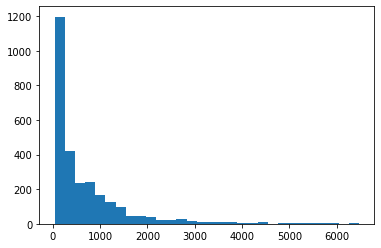

train_tar_max_len : 342


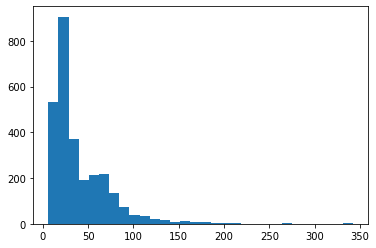

In [21]:
train_src_len = []
for m in train_src:
    m_len = len(m.split(' '))
    train_src_len.append(m_len)
print('train_src_max_len :', max(train_src_len))
plt.hist(train_src_len, bins=30)
plt.show()

train_tar_len = []
for m in train_tar:
    m_len = len(m.split(' '))
    train_tar_len.append(m_len)
print('train_tar_max_len :', max(train_tar_len))
plt.hist(train_tar_len, bins=30)
plt.show()

In [22]:
src_tokenizer.fit(train_src)
tar_tokenizer.fit(train_tar)

100%|██████████| 2794/2794 [00:00<00:00, 78745.90it/s]


In [23]:
train_src_tokens = src_tokenizer.txt2token(train_src)
val_src_tokens = src_tokenizer.txt2token(val_src)
test_src_tokens = src_tokenizer.txt2token(test_src)

train_tar_tokens = tar_tokenizer.txt2token(train_tar)
val_tar_tokens = tar_tokenizer.txt2token(val_tar)

100%|██████████| 200/200 [00:00<00:00, 62484.98it/s]


In [24]:
input_vocab_size = len(src_tokenizer.txt2idx)
target_vocab_size = len(tar_tokenizer.txt2idx)

In [25]:
input_vocab_size, target_vocab_size

(20002, 4877)

In [26]:
df_train.summary.iloc[0]

'제207회 완주군의회 임시회 제1차 본회의 개의 선포.'

In [27]:
train_tar_tokens[0], tar_tokenizer.convert(train_tar_tokens[0])

(array([   3,    8, 1131,   19,   42,   21,   24,    8,   35,   25,   49,
           5,   44,    5,   52,    2,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]),
 ' 제 207 회 완주군 의회 임시회 제 1 차 본회의개의선포.')

# 데이터셋

In [28]:
class CustomDataset(Dataset):
    def __init__(self, src_tokens, tar_tokens, mode='train'):
        self.mode = mode
        self.src_tokens = src_tokens
        if self.mode == 'train':
            self.tar_tokens = tar_tokens
            
    def __len__(self):
        return len(self.src_tokens)
    
    def __getitem__(self, i):
        src_token = self.src_tokens[i]
        if self.mode == 'train':
            tar_token = self.tar_tokens[i]
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long),
                'tar_token' : torch.tensor(tar_token, dtype=torch.long),
            }
        else:
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long)
            }

In [29]:
train_dataset = CustomDataset(train_src_tokens, train_tar_tokens)
val_dataset = CustomDataset(val_src_tokens, val_tar_tokens)
test_dataset = CustomDataset(test_src_tokens, None, 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

# load pretrained kobart model

In [32]:
model = get_kobart_for_conditional_generation()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

In [33]:
#optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 평가함수 정의

In [71]:
def rouge_function(labels,summary_ids,tar_tokenizer):

    pred_list = [tar_tokenizer.convert(g.to('cpu').tolist()) for g in summary_ids]
    real_list = [tar_tokenizer.convert(g.to('cpu').tolist()) for g in labels]

    result = metric.compute(predictions=pred_list,references=real_list)

    metric_result = {key:value.mid.fmeasure for key,value in result.items()}

    return metric_result['rouge1'],metric_result['rouge2'],metric_result['rougeL']

## 학습 정의

In [73]:
def train_step(model, batch_item, batch, training):
    input_ids = batch_item['src_token'].to(device)
    labels = batch_item['tar_token'].to(device)

    inputs = {'input_ids':input_ids,
                       'labels':labels}
  
    model.to(device)
    
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = model(**inputs).loss
            
            summary_ids = model.generate(input_ids, num_beams=4, early_stopping=True)

            rouge1,rouge2,rougeL = rouge_function(labels,summary_ids,tar_tokenizer)

        loss.backward()
        optimizer.step()
        lr = optimizer.param_groups[0]["lr"]
        return loss, rouge1,rouge2,rougeL, round(lr, 10)
    else:
        model.eval()
        with torch.no_grad():
            loss = model(**inputs).loss

            summary_ids = model.generate(input_ids, num_beams=4, early_stopping=True)

            rouge1,rouge2,rougeL = rouge_function(labels,summary_ids,tar_tokenizer)

        return loss, rouge1,rouge2,rougeL

## 학습

In [75]:
loss_plot, val_loss_plot = [], []
total_rouge1_plot, total_rouge2_plot, total_rougeL_plot = [] , [] , []
total_val_rouge1_plot, total_val_rouge2_plot, total_val_rougeL_plot = [] , [] , []

for epoch in range(epochs):
    gc.collect()
    total_loss, total_val_loss = 0, 0

    total_rouge1, total_rouge2, total_rougeL = 0,0,0

    total_val_rouge1, total_val_rouge2, total_val_rougeL = 0,0,0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, rouge1,rouge2,rougeL, lr = train_step(model, batch_item, batch, training)
        total_loss += batch_loss
        total_rouge1 += rouge1
        total_rouge2 += rouge2
        total_rougeL += rougeL
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'LR' : lr,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Total Rouge1' : total_rouge1/(batch+1), 'Total Rouge2' : total_rouge2/(batch+1), 'Total RougeL' : total_rougeL/(batch+1)
        })
    loss_plot.append(total_loss/(batch+1))
    total_rouge1_plot.append(total_rouge1/(batch+1)) 
    total_rouge2_plot.append(total_rouge2/(batch+1))
    total_rougeL_plot.append(total_rougeL/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, rouge1,rouge2,rougeL  = train_step(model, batch_item, batch, training)
        total_val_loss += batch_loss
        total_val_rouge1 += rouge1
        total_val_rouge2 += rouge2
        total_val_rougeL += rougeL
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Total Rouge1' : total_val_rouge1/(batch+1), 'Total Rouge2' : total_val_rouge2/(batch+1), 'Total RougeL' : total_val_rougeL/(batch+1)
          
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    total_val_rouge1_plot.append(total_val_rouge1/(batch+1)) 
    total_val_rouge2_plot.append(total_val_rouge2/(batch+1))
    total_val_rougeL_plot.append(total_val_rougeL/(batch+1))

699it [38:09,  3.27s/it, Epoch=1, LR=0.0001, Loss=0.581701, Rouge1=0, Rouge2=0, RougeL=0, Total Loss=2.035731, Total Rouge1=0.076, Total Rouge2=0.000298, Total RougeL=0.0758]
50it [00:52,  1.05s/it, Epoch=1, Val Loss=7.838231, Rouge1=0, Rouge2=0, RougeL=0, Total Val Loss=2.073901, Total Rouge1=0.0627, Total Rouge2=0.0025, Total RougeL=0.0627]
699it [38:11,  3.28s/it, Epoch=2, LR=0.0001, Loss=2.459792, Rouge1=0, Rouge2=0, RougeL=0, Total Loss=1.625558, Total Rouge1=0.0766, Total Rouge2=0.000955, Total RougeL=0.0757]
50it [00:52,  1.04s/it, Epoch=2, Val Loss=7.581832, Rouge1=0, Rouge2=0, RougeL=0, Total Val Loss=1.916621, Total Rouge1=0.0683, Total Rouge2=0, Total RougeL=0.063]


## 학습 결과

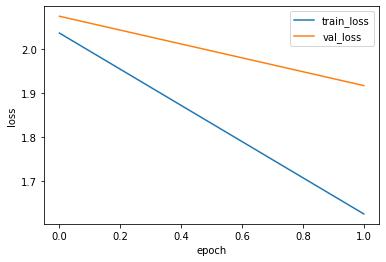

In [76]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

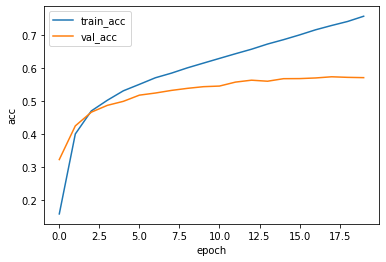

In [ ]:
plt.plot(total_rouge1_plot, label='train_rouge1')
plt.plot(total_val_rouge1_plot, label='val_rouge1')
plt.xlabel('epoch')
plt.ylabel('rouge1')
plt.legend()
plt.show()

In [ ]:
plt.plot(total_rouge2_plot, label='train_rouge2')
plt.plot(total_val_rouge2_plot, label='val_rouge2')
plt.xlabel('epoch')
plt.ylabel('rouge2')
plt.legend()
plt.show()

In [ ]:
plt.plot(total_rougeL_plot, label='train_rougeL')
plt.plot(total_val_rougeL_plot, label='val_rougeL')
plt.xlabel('epoch')
plt.ylabel('rougeL')
plt.legend()
plt.show()

## 추론

In [80]:
def evaluate(model, tar_tokenizer, tokens):
    
    summary_ids = model.generate(tokens, num_beams=4, early_stopping=True)

    pred_list = [tar_tokenizer.convert(g.to('cpu').tolist()) for g in summary_ids]

    return pred_list


In [82]:
tqdm_dataset = tqdm(enumerate(val_dataloader))
preds = []
#tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(model, tar_tokenizer, batch_item['src_token'].to(device))
    preds.extend(output)
    #tokens.extend(output[1])

50it [00:29,  1.70it/s]


In [83]:
for i, (a, p) in enumerate(zip(df_val.summary, preds)):
    print('정답 :', a)
    print('예측 :', p)
    print('=================================================================================')
    if i == 10:
        break

정답 : 음성군 경로당 지원 조례 일부개정조례안은 경로당 이용에 대한 여건 및 특수성에 따라 기존 미등록 경로당 등록기준을 완화하고, 경로당 양곡 지원에 대한 근거를 마련하는 등 경로당 이용 어르신들의 건강증진 및 복지향상에 기여하기 위해 개정함. 해당 안건은 가결되었음.
예측 : os 음성군 년도 공유 재산 관리 계획 변경 동의 안은 음성군 공유 재산 취득 계획 변경
정답 : 음성군 군세 징수 조례 일부개정조례안과 2019년 재산세 도시지역분 적용대상 지역 고시안은 <음성군 행정기구 설치 조례>가 2019년 1월 1일 전부개정됨에 따라 변경된 사항을 조례에 반영하기 위해 제정함. 해당 안건은 가결되었음.
예측 : os 음성군 년도 공유 재산 관리 계획 변경 계획안은 음성군 공유 재산 취득 계획 변경 변경
정답 : 음성군 폐기물 관리 조례 일부개정조례안은 쓰레기처리비 대비 수수료 수입비율인 주민부담율이 낮아 청소행정의 건전 재정을 저해하고 불법반입 폐기물이 증가하는 문제가 있어 지역 실정에 맞도록 쓰레기 종량제 수수료를 조정하고자 제정함. 해당 안건은 가결 되었음.
예측 : os 음성군 년도 공유 재산 관리 계획 변경 계획안 제안 설명.
정답 : 음성군 농업기계 사후관리 출장비용 지원 조례안은 음성군 농업인의 농업생산성 향상과 경영 개선, 기계화 영농 편의 등을 제공하고 농업기계 안전사용을 도모하기 위해 제정함. 해당 안건은 가결되었음.
예측 : os 음성군 년도 공유 재산 관리 계획 변경 동의 안은 음성군 공유 재산 취득 계획 변경
정답 : 일반농산어촌개발사업 공유재산 시설물 관리위탁 운영 동의안은 조성한 시설물의 효율적인 관리를 위해 추진위원회에 그 재산의 관리를 위탁하고자 하는 것에 동의를 구하기 위해 발의됨. 해당 안건은 가결되었음.
예측 : os 음성군 년도 공유 재산 관리 계획 변경 계획안 제안 설명.
정답 : 제251회 음성군의회 제2차 정례회 제3차 본회의 개의.
예측 : os 제 276 회 음성군 의회 임시회 제 1 차 본회의개의선포.
정답 :

## 제출

In [84]:
tqdm_dataset = tqdm(enumerate(test_dataloader))
preds = []
#tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(model, tar_tokenizer, batch_item['src_token'].to(device))
    preds.extend(output)
    #tokens.extend(output[1])

127it [01:14,  1.72it/s]


In [86]:
submission = pd.read_csv('/content/sample_submission.csv')

In [87]:
submission['summary'] = preds

In [88]:
submission.head()

,uid,summary
0,id_2000-AGENDA_1,os 제 170 회 음성군 의회 임시회 제 1 차 본회의개의선포.
1,id_2000-AGENDA_2,os 제 276 회 음성군 의회 임시회 회기는 4 월 16 일부터 9 월 18 일
2,id_2000-AGENDA_3,os 제 170 회 임시회 회의록 서명 의원으로 정태완 의원과 정태완 의원이 선출됨.
3,id_2000-AGENDA_4,"os 제 결산 회 세입 , 세출 결산 검사 대표 휴회가 가결됨."
4,id_2000-AGENDA_5,"os 2020 년도 행정 사무 감사 시정 , 건의사항 조치 결과 보고."


In [89]:
submission.to_csv('dacon_baseline.csv', index=False)